In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import h5py
import re

In [2]:
np.__version__

'1.21.6'

In [3]:
directory = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4/all_cre_clustering_090923_select_k/'

# Regular expression to match the desired file names
pattern = r'cluster_meta_n_(\d+)_clusters\.h5'

# Function to extract the number from the file name
def extract_number(filename):
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    return -1

# Get a list of all files in the directory
all_files = os.listdir(directory)

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [5]:
filename = 'cluster_meta_n_14_clusters.h5'

In [6]:
file_path = os.path.join(directory, filename)
cluster_df = pd.read_hdf(file_path, key='df')

In [36]:
### functions
def get_table_long(cluster_df_all, location='area_layer', cluster_range = range(0, 12)):
    cluster_df_all['location'] = cluster_df_all[location].copy()
    table_cre = pd.DataFrame()
    
    for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
        areas = locations[location]
    
        # compute the table of proportions
        table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
        # make sure that there are 12 clusters for all
        table = table.reindex(cluster_range).reset_index()
   
        # add cre line
        table['cre_line'] = cre
        if i == 0:
            table_cre=table.copy()
        else:
            # concatinate tables with all cre
            table_cre = pd.concat([table_cre, table], ignore_index=True)

    # start with 1
    table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

    # convert to long format
    table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')

    return table_long

#### load cell table to find area and depth

In [7]:
import visual_behavior.data_access.loading as loading
cell_table = loading.get_cell_table()

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


In [8]:
cell_specimen_ids = cluster_df.cell_specimen_id.values

In [9]:
cell_table2 = cell_table[cell_table.cell_specimen_id.isin(cell_specimen_ids)]

In [10]:
cell_table2.keys()

Index(['cell_specimen_id', 'ophys_experiment_id', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'experience_level', 'passive', 'image_set', 'file_id',
       'cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'area_layer', 'date', 'first_novel',
       'n_relative_to_first_novel', 'last_familiar', 'last_familiar_active',
       'second_novel', 'second_novel_active', 'experience_exposure'],
      dtype='object')

In [11]:
cell_table3 = cell_table2[['cell_specimen_id','cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'area_layer', 'targeted_structure']]
cell_table4 = cell_table3.drop_duplicates('cell_specimen_id')

In [12]:
cluster_df_all = pd.merge(cluster_df, cell_table4, on='cell_specimen_id', how='inner')

In [13]:
cluster_df_all['location'] = cluster_df_all['area_layer'].copy()

#### use GLM clustering code to generate the area/depth analysis

In [14]:
import visual_behavior_glm.GLM_clustering as glm_clust

In [15]:
cluster_df_all.location.unique()

array(['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower'],
      dtype=object)

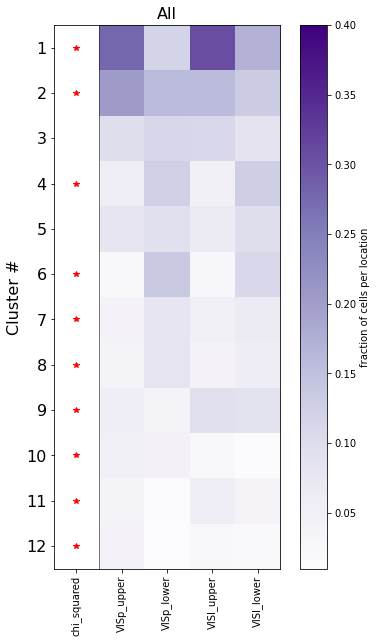

In [16]:
areas = ['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']
cre = 'none'
fig, ax = plt.subplots(1,1, figsize = (7,10))
glm_clust.plot_proportion_cre(df=cluster_df_all, areas=areas, fig=fig, ax=ax, cre=cre,test='chi_squared_')

#### Use cre lines

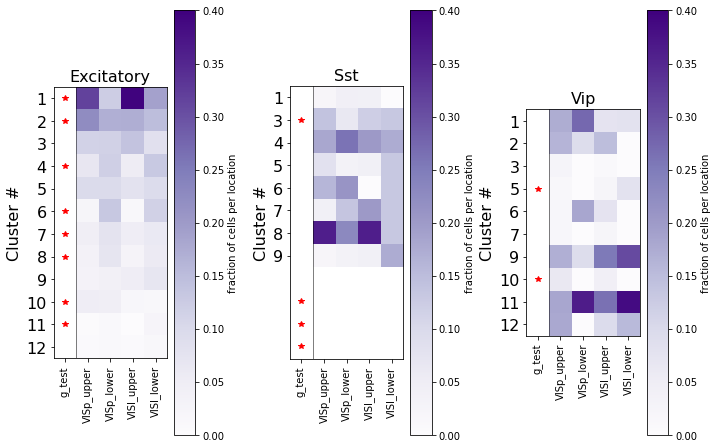

In [17]:
areas = ['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']

fig, ax = plt.subplots(1,3, figsize = (10,7))
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    glm_clust.plot_proportion_cre(df=cluster_df_all, areas=areas, fig=fig, ax=ax[i], cre=cre,test='g_test_')

plt.tight_layout()

Primary visual cortex:
- Overrepresentation of cluster 10 that is modulated by task during novelty. This is super interesting cause you would expect higher visual areas to integrate task related behaviors. This may be related to stronger modulation by movement or licking in the novel session. 

- When using g test, we do not see significant difference in areas for beahvioral cluster 9, which often pops up more LM based.

- non responsive cells are likely to be in superficial layers.

- Novelty cells are prominent in superficial V1.

- Deep layers are more consistently responding to all images, including familiar only. 

- Suppression by novelty excitatory cells are more common in deep layers, while SST are in superficial layers.

#### Bar plot of area and depth representation

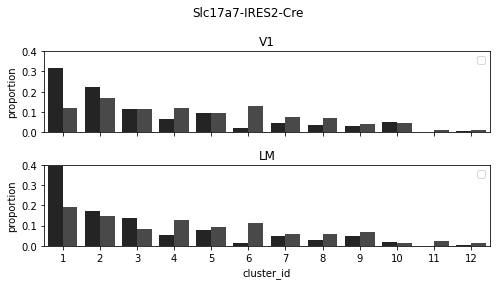

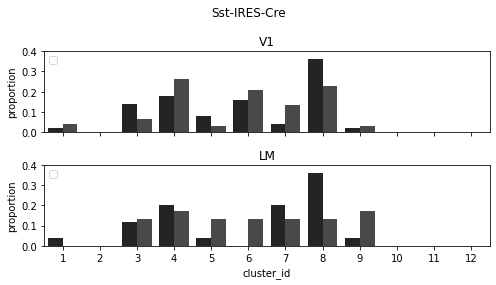

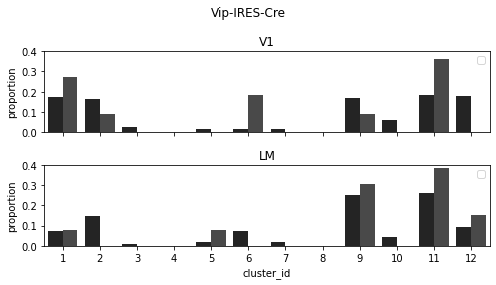

In [18]:

grey_palette = sns.color_palette("gray")
legend=True
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
   
    fig, ax = plt.subplots(2,1, figsize = (7,4), sharex=True)
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    cluster_range = range(0, 12)
    table = table.reindex(cluster_range).reset_index()
    table['cluster_id'] = table['cluster_id'].copy()+1
    table_VISp = table[['cluster_id', 'VISp_upper', 'VISp_lower']]
    table_VISl = table[['cluster_id', 'VISl_upper', 'VISl_lower']]
    df_visp = pd.melt(table_VISp, id_vars=['cluster_id'], var_name='location', value_name='proportion')
    df_visl = pd.melt(table_VISl, id_vars=['cluster_id'], var_name='location', value_name='proportion')

    sns.barplot(data=df_visp, x='cluster_id', y='proportion', hue='location', palette=grey_palette, ax=ax[0])
    sns.barplot(data=df_visl, x='cluster_id', y='proportion', hue='location', palette=grey_palette, ax=ax[1])
    # if legend is True:
    #     legend=False
    # else:
    #     ax[1].legend('')
    
    # stats
    test='g_test_'
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    
    ax[0].set_ylim([0, 0.4])
    ax[0].set_title('V1')
    ax[0].legend('')
    ax[0].set_xlabel('')
    ax[1].set_ylim([0, 0.4])
    ax[1].set_title('LM')
    ax[1].legend('')
    plt.suptitle(cre)
    plt.tight_layout()


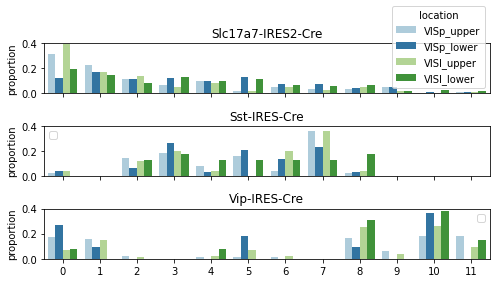

In [19]:

### plot on one bar plot

grey_palette = sns.color_palette("gray")
legend=True
fig, ax = plt.subplots(3,1, figsize = (7,4), sharex=True)

for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
   
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    cluster_range = range(0, 12)
    table = table.reindex(cluster_range).reset_index()
    
    table_long = pd.melt(table, id_vars=['cluster_id'], var_name='location', value_name='proportion')

    sns.barplot(data=table_long, x='cluster_id', y='proportion', hue='location', palette='Paired', ax=ax[i])
    # if legend is True:
    #     legend=False
    # else:
    #     ax[1].legend('')
    
    # stats
    test='g_test_'
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    
    ax[i].set_ylim([0, 0.4])
    ax[i].set_title(cre)
    if i > 0:
        ax[i].legend('')
    ax[i].set_xlabel('')
   
    plt.tight_layout()


In [20]:
locations = {'targeted_structure': ['VISp', 'VISl'],
            'layer': ['upper', 'lower'],
            'area_layer':['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']}


In [21]:
# table_cre = table_cre[['cluster_id', 'cre_line', *locations[location]]]

### By different location per cluster

#### area

In [22]:
#get cluster df for specific location
location = 'targeted_structure'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')



In [23]:
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1


In [24]:
table2_cre.sample()

location,cluster_id,VISp,VISl,VISp_chance_count,VISl_chance_count,g_test_pvalue,significant,imq,bh_significant,cre_line
11,12,23.0,6.0,23.812007,5.187993,0.699544,False,0.045833,False,Slc17a7-IRES2-Cre


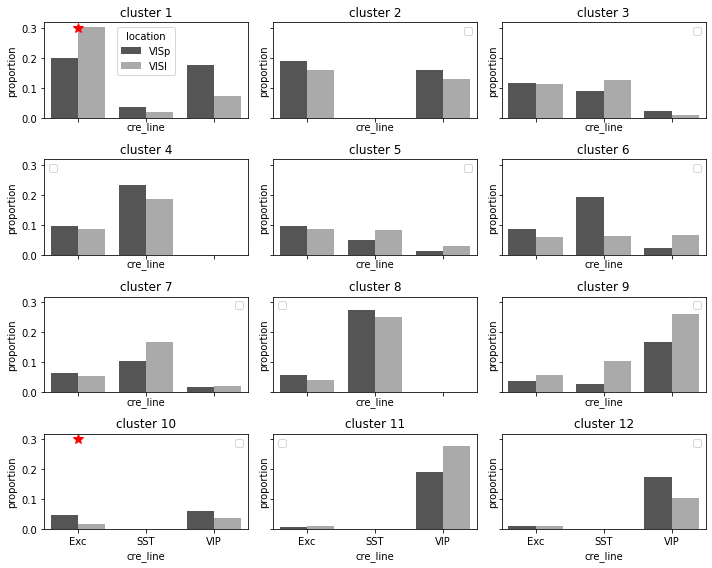

In [29]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
    if j > 0:
        ax.legend('')
    # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==j+1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant'] is True:
            ax.plot(index, 0.3,'r*', markersize = 10)
plt.tight_layout()  

#### layer

In [30]:
#get cluster df for specific location
location = 'layer'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')



In [31]:
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1



In [32]:
table2_cluster = table2_cre[table2_cre['cluster_id']==2][['cre_line', 'bh_significant']].reset_index(drop=True)
table2_cluster 

location,cre_line,bh_significant
0,Slc17a7-IRES2-Cre,True
1,Sst-IRES-Cre,NaN
2,Vip-IRES-Cre,False


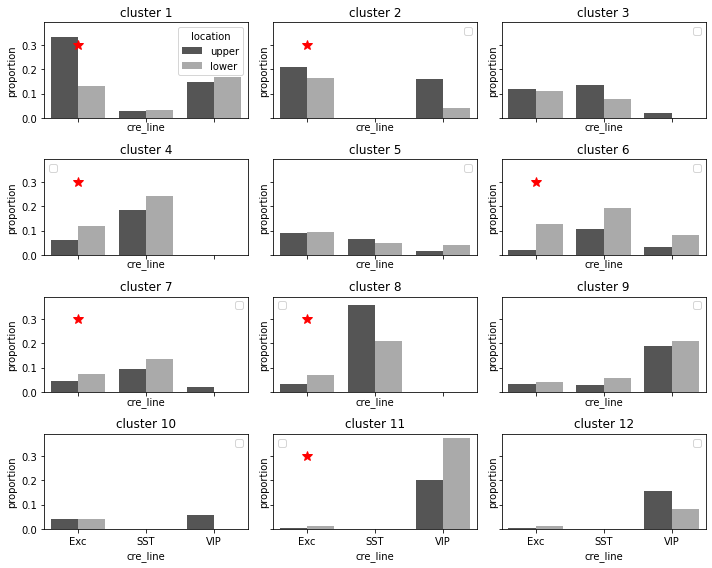

In [33]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
    if j > 0:
        ax.legend('')
     # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==j+1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant'] is True:
            ax.plot(index, 0.3,'r*', markersize = 10)
plt.tight_layout()  

#### area and depth

In [37]:
#get cluster df for specific location
location = 'area_layer'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')


In [38]:
test = 'g_test_'
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reindex(cluster_range).reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1

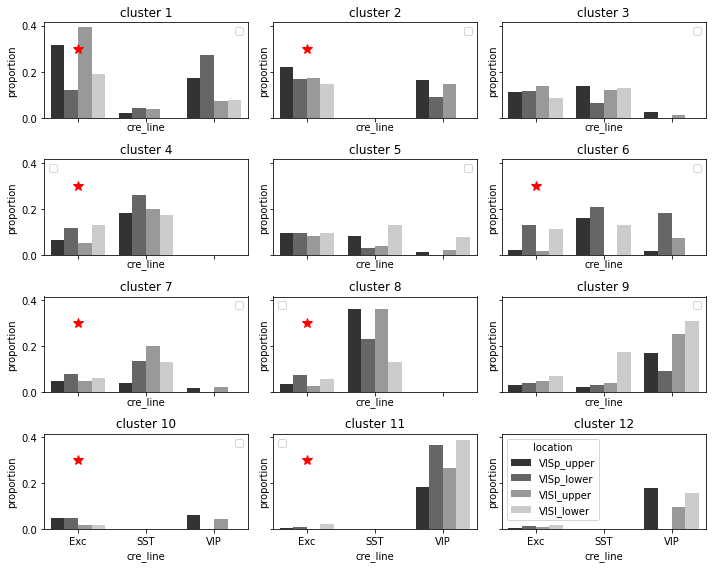

In [39]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
     # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==j+1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant'] is True:
            ax.plot(index, 0.3,'r*', markersize = 10)
    if j != 11:
        ax.legend('')
plt.tight_layout()  



In [40]:
table2_cluster

location,cre_line,bh_significant
0,Slc17a7-IRES2-Cre,False
1,Sst-IRES-Cre,NaN
2,Vip-IRES-Cre,False


In [41]:
table_long[['area', 'layer']] = table_long['location'].str.split('_', expand=True)


In [42]:
table_layer = table_long.copy()

In [43]:
# Create new columns 'upper' and 'lower' based on 'layer' column
table_layer['upper'] = table_long['proportion'][table_long['layer'] == 'upper']
table_layer['lower'] = table_long['proportion'][table_long['layer'] == 'lower']

# Drop the 'layer' column
table_layer = table_layer.drop(columns=['layer'])

In [44]:
table2_layer = table_layer.groupby(['cluster_id', 'cre_line','area']).mean().reset_index()

In [45]:
table2_layer 

,cluster_id,cre_line,area,proportion,upper,lower
0,1,Slc17a7-IRES2-Cre,VISl,0.292305,0.394495,0.190114
1,1,Slc17a7-IRES2-Cre,VISp,0.218255,0.315884,0.120625
2,1,Sst-IRES-Cre,VISl,0.020000,0.040000,0.000000
3,1,Sst-IRES-Cre,VISp,0.030833,0.020000,0.041667
4,1,Vip-IRES-Cre,VISl,0.075304,0.073684,0.076923
...,...,...,...,...,...,...
67,12,Slc17a7-IRES2-Cre,VISp,0.008020,0.005415,0.010625
68,12,Sst-IRES-Cre,VISl,NaN,NaN,NaN
69,12,Sst-IRES-Cre,VISp,NaN,NaN,NaN
70,12,Vip-IRES-Cre,VISl,0.124291,0.094737,0.153846


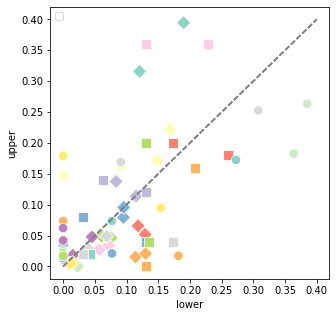

In [46]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
markers = ['D', 's', '8']
for c, cre in enumerate(table2_layer.cre_line.unique()):
    sns.scatterplot(data=table2_layer[table2_layer.cre_line==cre] , x = 'lower', y = 'upper', 
                    hue = 'cluster_id', palette = 'Set3', s=100, marker=markers[c], ax=ax)
    ax.legend('')
    plt.plot([0, 0.4], [0,0.4], '--', color='gray')

### Modulation index by layer (table2_layer)

In [47]:
table2_layer['modulation_index'] = (table2_layer['upper'] - table2_layer['lower']) / (table2_layer['lower'] + table2_layer['upper'])


Text(0.5, 1.0, 'compbined across areas')

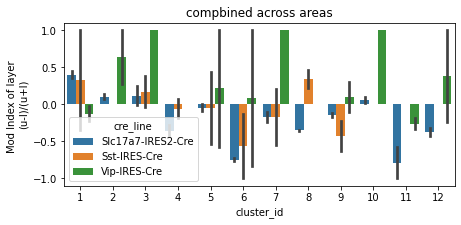

In [48]:
fig, ax= plt.subplots(1,1,figsize = (7,3))
ax=sns.barplot(data=table2_layer, x='cluster_id', y='modulation_index', hue='cre_line', ax=ax)
ax.set_ylabel('Mod Index of layer \n(u-l)/(u+l)')
ax.set_title('compbined across areas')

### Modulation index by area

In [49]:
table_long= get_table_long(cluster_df_all)
table_long.head()

,cluster_id,cre_line,location,proportion
0,1,Slc17a7-IRES2-Cre,VISp_upper,0.315884
1,2,Slc17a7-IRES2-Cre,VISp_upper,0.222022
2,3,Slc17a7-IRES2-Cre,VISp_upper,0.113718
3,4,Slc17a7-IRES2-Cre,VISp_upper,0.065884
4,5,Slc17a7-IRES2-Cre,VISp_upper,0.095668


In [50]:
table_long[['targeted_structure', 'layer']] = table_long['location'].str.split('_', expand=True)
table_area = table_long.copy()
table_area['VISp'] = table_long['proportion'][table_long['targeted_structure'] == 'VISp']
table_area['VISl'] = table_long['proportion'][table_long['targeted_structure'] == 'VISl']

# Drop the 'layer' column
table_area = table_area.drop(columns=['targeted_structure'])

In [51]:
table_area 

,cluster_id,cre_line,location,proportion,layer,VISp,VISl
0,1,Slc17a7-IRES2-Cre,VISp_upper,0.315884,upper,0.315884,NaN
1,2,Slc17a7-IRES2-Cre,VISp_upper,0.222022,upper,0.222022,NaN
2,3,Slc17a7-IRES2-Cre,VISp_upper,0.113718,upper,0.113718,NaN
3,4,Slc17a7-IRES2-Cre,VISp_upper,0.065884,upper,0.065884,NaN
4,5,Slc17a7-IRES2-Cre,VISp_upper,0.095668,upper,0.095668,NaN
...,...,...,...,...,...,...,...
139,8,Vip-IRES-Cre,VISl_lower,NaN,lower,NaN,NaN
140,9,Vip-IRES-Cre,VISl_lower,0.307692,lower,NaN,0.307692
141,10,Vip-IRES-Cre,VISl_lower,0.000000,lower,NaN,0.000000
142,11,Vip-IRES-Cre,VISl_lower,0.384615,lower,NaN,0.384615


In [52]:
table2_area = table_area.groupby(['cluster_id', 'cre_line','layer']).mean().reset_index()

table2_area['modulation_index'] = (table2_area['VISp'] - table2_area['VISl']) / (table2_area['VISp'] + table2_area['VISl'])


Text(0.5, 1.0, 'compbined across layers')

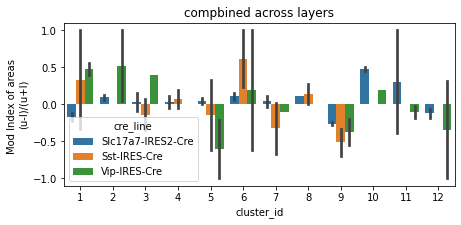

In [53]:
fig, ax= plt.subplots(1,1,figsize = (7,3))
ax=sns.barplot(data=table2_area, x='cluster_id', y='modulation_index', hue='cre_line', ax=ax)
ax.set_ylabel('Mod Index of areas \n(u-l)/(u+l)')
ax.set_title('compbined across layers')

In [54]:
combiend_table = table2_layer.copy()

In [55]:
combiend_table = combiend_table.join(table2_area[['modulation_index']], lsuffix= '_layer', rsuffix='_area')

In [56]:
combiend_table.head()

,cluster_id,cre_line,area,proportion,upper,lower,modulation_index_layer,modulation_index_area
0,1,Slc17a7-IRES2-Cre,VISl,0.292305,0.394495,0.190114,0.349603,-0.223625
1,1,Slc17a7-IRES2-Cre,VISp,0.218255,0.315884,0.120625,0.447320,-0.110660
2,1,Sst-IRES-Cre,VISl,0.020000,0.040000,0.000000,1.000000,1.000000
3,1,Sst-IRES-Cre,VISp,0.030833,0.020000,0.041667,-0.351351,-0.333333
4,1,Vip-IRES-Cre,VISl,0.075304,0.073684,0.076923,-0.021505,0.560000


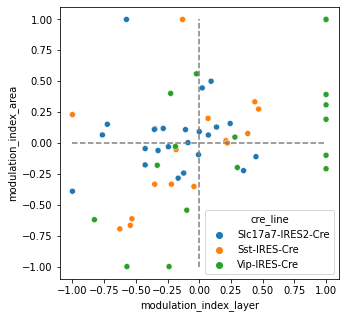

In [57]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
sns.scatterplot(data=combiend_table, x='modulation_index_layer', y = 'modulation_index_area', hue = 'cre_line')
plt.plot([0, 0], [-1,1], '--', color='gray')
plt.plot([-1, 1], [0,0], '--', color='gray')

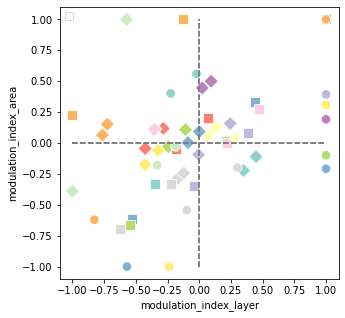

In [58]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
markers = ['D', 's', '8']
for c, cre in enumerate(combiend_table.cre_line.unique()):
    sns.scatterplot(data=combiend_table[combiend_table.cre_line==cre], x='modulation_index_layer', y = 'modulation_index_area', hue = 'cluster_id',
         palette = 'Set3', s=100, marker=markers[c], ax=ax)
    ax.legend('')
    plt.plot([0, 0], [-1,1], '--', color='gray')
    plt.plot([-1, 1], [0,0], '--', color='gray')
    
    
    ### take a mean!!! 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


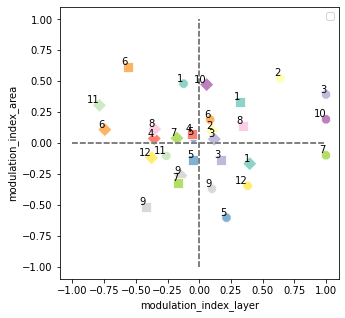

In [59]:
combined_mean_table = combiend_table.groupby(['cluster_id', 'cre_line']).mean().reset_index()
fig, ax = plt.subplots(1,1, figsize = (5,5))
markers = ['D', 's', '8']
for c, cre in enumerate(combined_mean_table.cre_line.unique()):
    sns.scatterplot(data=combined_mean_table[combined_mean_table.cre_line==cre], x='modulation_index_layer', y = 'modulation_index_area', hue = 'cluster_id',
         palette = 'Set3', s=100, marker=markers[c], ax=ax)
    for cluster_id in range(1,13):
        cluster_table = combined_mean_table[(combined_mean_table.cre_line==cre) &
                                           (combined_mean_table.cluster_id==cluster_id)]
        plt.text(cluster_table['modulation_index_layer'], cluster_table['modulation_index_area'], str(cluster_id), ha='right', va='bottom')
    ax.legend('')
    plt.plot([0, 0], [-1,1], '--', color='gray')
    plt.plot([-1, 1], [0,0], '--', color='gray')
    
    

In [60]:
fig, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data=combined_mean_table, x='modulation_index_layer', y = 'modulation_index_area', hue = 'cre_line',
              s=100, ax=ax)
for c, cre in enumerate(combined_mean_table.cre_line.unique()):
    for cluster_id in range(1,13):
        cluster_table = combined_mean_table[(combined_mean_table.cre_line==cre) &
                                           (combined_mean_table.cluster_id==cluster_id)]    
        plt.text(cluster_table['modulation_index_layer'], cluster_table['modulation_index_area'], str(cluster_id), ha='right', va='bottom')
#     ax.legend('')
plt.plot([0, 0], [-1,1], '--', color='gray')
plt.plot([-1, 1], [0,0], '--', color='gray')
33ax.set_ylabel( '<- LM --- V1 ->')
ax.set_xlabel( '<- lower --- upper ->')
   

SyntaxError: invalid syntax (3754268287.py, line 13)

### Change dot size

In [61]:
combined_mean_table['size_col'] = combined_mean_table['proportion'].copy()

In [62]:
from visual_behavior_glm import GLM_visualization_tools as gvt

In [63]:
color_map = []
for c, cre in enumerate(combined_mean_table.cre_line.unique()):
    color_map.append(gvt.project_colors()[cre])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


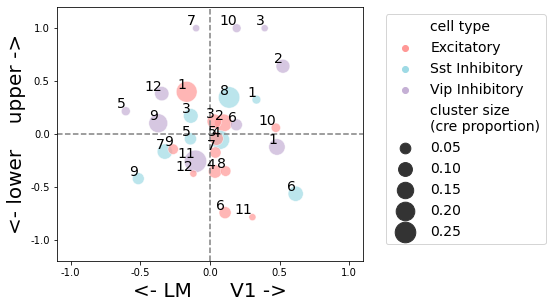

In [64]:
fig, ax = plt.subplots(1,1, figsize = (8,4.5))
plt.rcParams['font.size'] = 14
sns.scatterplot(data=combined_mean_table, y='modulation_index_layer', x = 'modulation_index_area', hue = 'cre_line',
              size='size_col', palette = color_map, sizes=(50, 500), alpha=0.7, ax=ax)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
text = legend.get_texts()
for c, cre in enumerate(combined_mean_table.cre_line.unique()):
    for cluster_id in range(1,13):
        cluster_table = combined_mean_table[(combined_mean_table.cre_line==cre) &
                                           (combined_mean_table.cluster_id==cluster_id)]    
        plt.text(cluster_table['modulation_index_area'], cluster_table['modulation_index_layer'], str(cluster_id), ha='right', va='bottom')
#     ax.legend('')
plt.plot([0, 0], [-1.2,1.4], '--', color='gray')
plt.plot([-1.1, 1.1], [0,0], '--', color='gray')
ax.set_xlabel( '<- LM      V1 ->', fontsize=20)
ax.set_xticks([-1, -.5, 0, .5, 1])
ax.set_xlim([-1.1, 1.1])
ax.set_xticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0']) 
ax.set_ylabel( '<- lower    upper ->', fontsize=20)
ax.set_yticks([-1, -.5, 0, .5, 1])
ax.set_ylim([-1.2, 1.2])
ax.set_yticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0']) 
text[0].set_text('cell type')
text[1].set_text('Excitatory')
text[2].set_text('Sst Inhibitory')
text[3].set_text('Vip Inhibitory')
text[4].set_text('cluster size \n(cre proportion)')
plt.tight_layout()
   

### Cell metrics
                 

In [67]:
%%time
data_type = 'filtered_events'

condition = 'images'
stimuli = 'all_images'
session_subset = 'full_session'

inclusion_criteria = 'platform_experiment_table'
    
import visual_behavior.ophys.response_analysis.cell_metrics as cm 

response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


  9%|███████                                                                          | 35/402 [00:03<00:28, 12.87it/s]

problem for experiment 891994418


 12%|██████████                                                                       | 50/402 [00:04<00:26, 13.16it/s]

problem for experiment 948507789


 23%|██████████████████▋                                                              | 93/402 [00:08<00:23, 13.28it/s]

problem for experiment 994790561


 35%|███████████████████████████▊                                                    | 140/402 [00:12<00:19, 13.10it/s]

problem for experiment 993369859


 36%|████████████████████████████▋                                                   | 144/402 [00:13<00:25, 10.32it/s]

problem for experiment 993891845


 39%|██████████████████████████████▊                                                 | 155/402 [00:14<00:21, 11.42it/s]

problem for experiment 994082680


 46%|████████████████████████████████████▊                                           | 185/402 [00:17<00:19, 11.27it/s]

problem for experiment 851085100


 47%|█████████████████████████████████████▌                                          | 189/402 [00:17<00:19, 10.77it/s]

problem for experiment 851085109


 48%|██████████████████████████████████████▍                                         | 193/402 [00:17<00:18, 11.51it/s]

problem for experiment 851085105


 51%|████████████████████████████████████████▊                                       | 205/402 [00:18<00:14, 13.70it/s]

problem for experiment 991852002


 52%|█████████████████████████████████████████▉                                      | 211/402 [00:19<00:15, 12.72it/s]

problem for experiment 991852001


 55%|███████████████████████████████████████████▊                                    | 220/402 [00:20<00:15, 11.93it/s]

problem for experiment 991852004


 55%|████████████████████████████████████████████▍                                   | 223/402 [00:20<00:13, 12.90it/s]

problem for experiment 991852005


 65%|███████████████████████████████████████████████████▋                            | 260/402 [00:23<00:13, 10.72it/s]

problem for experiment 977978321


 68%|██████████████████████████████████████████████████████▌                         | 274/402 [00:24<00:09, 13.26it/s]

problem for experiment 981178537


 70%|███████████████████████████████████████████████████████▋                        | 280/402 [00:25<00:09, 13.25it/s]

problem for experiment 882551935


 71%|█████████████████████████████████████████████████████████                       | 287/402 [00:26<00:09, 12.69it/s]

problem for experiment 882551937


 72%|█████████████████████████████████████████████████████████▉                      | 291/402 [00:26<00:08, 12.92it/s]

problem for experiment 882551947


 74%|██████████████████████████████████████████████████████████▉                     | 296/402 [00:26<00:07, 15.06it/s]

problem for experiment 951213203


 81%|████████████████████████████████████████████████████████████████▍               | 324/402 [00:29<00:06, 11.65it/s]

problem for experiment 1050762972


 82%|█████████████████████████████████████████████████████████████████▎              | 328/402 [00:29<00:06, 10.84it/s]

problem for experiment 1051249031
problem for experiment 1051423446


 87%|█████████████████████████████████████████████████████████████████████▎          | 348/402 [00:31<00:04, 12.28it/s]

problem for experiment 1076776838


 90%|████████████████████████████████████████████████████████████████████████        | 362/402 [00:32<00:04,  9.81it/s]

problem for experiment 1078904675


 93%|██████████████████████████████████████████████████████████████████████████▏     | 373/402 [00:33<00:02, 11.48it/s]

problem for experiment 1077597082
problem for experiment 1082841182


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:36<00:00, 10.97it/s]
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 376 experiments in the returned cell_metrics table


In [70]:
response_metrics.keys()

Index(['cell_specimen_id', 'pref_image', 'non_pref_image',
       'image_selectivity_index', 'image_selectivity_index_one_vs_all',
       'lifetime_sparseness', 'mean_response',
       'fraction_significant_p_value_gray_screen', 'fano_factor',
       'reliability', 'running_modulation_index', 'ophys_experiment_id',
       'condition', 'session_subset', 'stimuli', 'data_type', 'interpolate',
       'output_sampling_rate', 'response_window', 'use_events',
       'filter_events', 'equipment_name', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'cre_line',
       'indicator', 'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id', 'cell_type',

In [78]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'

save_dir = os.path.join(base_dir, 'all_cre_clustering_082823_n_14')
n_clusters = 14 # arbitrary choice that happens to pull out similar clusters to within cre clustering

cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')


filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(save_dir, filename), key='df')
   

In [88]:
## get pivoted results
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas
import visual_behavior.data_access.utilities as utilities
import visual_behavior.data_access.loading as loading


In [86]:
glm_version = '24_events_all_L2_optimize_by_session'

run_params, results, results_pivoted, weights_df = gfd.load_analysis_dfs(version)

# get across session normalized dropout scores
df, failed_cells = gas.load_cells(glm_version, clean_df=True)
df = df.set_index('identifier')

loading run_params
loading results df
loading results_pivoted df
loading weights_df
Loading list of matched cells


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


Loading across session normalized dropout scores


100%|██████████████████████████████████████████████████████████████████████████████| 3921/3921 [03:05<00:00, 21.14it/s]


0 cells could not be loaded


In [89]:
# only use across session values
across = df[[key for key in df.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
results_pivoted = across.copy()
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
print(len(results_pivoted), 'len(results_pivoted)')


# only use across session values
across = df[[key for key in df.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
results_pivoted = across.copy()
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
print(len(results_pivoted), 'len(results_pivoted)')


11763 len(results_pivoted)
11763 len(results_pivoted)


In [90]:
# load experiments table
experiments_table = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

3921 cells in matched cells table


In [91]:
# limit to matched cells 
results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)]
results_pivoted = results_pivoted[results_pivoted.cell_specimen_id.isin(matched_cells)]

# drop duplicates
results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
print(len(results_pivoted), 'len(results_pivoted) after dropping duplicates')
        
print(len(results_pivoted.cell_specimen_id.unique()),
      'cells in results_pivoted after limiting to strictly matched cells')

11763 len(results_pivoted) after dropping duplicates
3921 cells in results_pivoted after limiting to strictly matched cells


In [92]:
# limit to features used for clustering
features = processing.get_features_for_clustering()
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

In [77]:
feature_matrix

all-images                     omissions                      \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1   
cell_specimen_id                                                                
1086489847         0.000000  0.060457  0.017832  0.000000  0.000000  0.000000   
1086489860         0.000000  0.910349  0.000000  0.000000  0.109417  0.000000   
1086489891         0.000000  0.279929  0.000000  0.524089  0.000000  0.000000   
1086489976         0.817370  0.000000  0.000000  0.000000  0.000000  0.000000   
1086490002         0.852927  0.000000  0.355870  0.000000  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
1120133342         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1120133375         0.000000  0.614797  0.000000  0.000000  0.000000  0.000000   
1120133471         0.959608  0.000000  0.000000  0.056069  0.000000  0.000000   
1120133515         0.000000  0.962836  0.813388  0.000000  0.000000  0.000000   
1120133649         0.165861  0.454973  0.196244  0.000000  0.091243  0.051029   

                 behavioral                          task                      
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                               
1086489847         0.000000  0.084897  0.971563  0.000000  0.004045  0.009827  
1086489860         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086489891         0.168301  0.008724  1.000000  0.000000  0.025777  0.000000  
1086489976         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086490002         0.000000  0.000000  0.000000  0.021871  0.000000  0.000000  
...                     ...       ...       ...       ...       ...       ...  
1120133342         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1120133375         0.000000  0.319157  0.000000  0.000000  0.012979  0.000000  
1120133471         0.000000  0.000000  0.000000  0.054291  0.000000  0.000000  
1120133515         0.000000  0.000000  0.232246  0.000000  0.000000  0.000000  
1120133649         0.078284  0.376749  0.350971  0.020329  0.065492  0.068512  

[3921 rows x 12 columns]

In [94]:
coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)

ValueError: attempt to get argmax of an empty sequence